# Simulate High Flux for 'Radiometric_Error_Analysis.ipynb'

Simulate the return from a hard target surface (like the ground or cloud)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time
import xarray as xr
import pickle
from pathlib import Path

# import library for simulating Poisson point processes
cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import sim_deadtime_utils as sim
from load_ARSENL_data import set_binwidth

eps = sys.float_info.epsilon

In [32]:
# Constants

c = 299792458  # [m/s] speed of light
k_B = 1.380649e-23  # [m^2 kg s-2 K-1]
g_0 = 9.81  # [m s-2] Gravity
M_air = 28.97  # [g/mol] Molar mass of air
R_0 = 8.314459  # [J/mol/K] Universal gas constant
N_A = 6.022e23  # [atoms / mol] Avogadro's number
h = 6.626e-34  # [J s] Planck's constant

fL = 2e3  # [Hz] laser rep rate for ABLE
tD = 20e-9  # [Hz] deadtime

In [34]:
amp = 3e6  # [Hz] amplitude of step (cloud or surface)
mu = 15   # [m] where the surface is
r_ABLE_bin = 30  # [m] the extend of the range bin
bgd = 0  # [Hz] background
t_res = 250e-12  # [s] very fine (almost time tag) resolution

num_bins = int(r_ABLE_bin/c*2//t_res)  # number of "time tage" bins within major bin

r_sim_bins = np.linspace(0, r_ABLE_bin, num_bins)  # [m]
t_sim_bins = r_sim_bins/c*2  # [s]
loc_center = np.round(mu/r_ABLE_bin * num_bins).astype(int)

flux = np.zeros(num_bins)  # [Hz]
flux[loc_center:] = 1  # [Hz] generate step function for flux
photon_rate_arr = flux * amp # [Hz]

### Simulate retrieval

In [44]:
Nshot = 2000
print('{} shots'.format(Nshot))
print('{:.3f} sec of simulated data'.format(Nshot/fL))

2000 shots
1.000 sec of simulated data


In [51]:
##### GENERATE SIMULATED DATA #####

# simulation resolution settings
if type(Nshot) != int:
    Nshot = int(Nshot)  # number of laser shots

wrap_deadtime = False

# generate photon counts

# lists of photon arrivals per laser shot
start = time.time()
t_det_lst = []  # detected photons (includes deadtime)
t_phot_lst = []  # actual photons (no dead time)
sync_idx = np.arange(Nshot)  # sync value
det_sync_idx = []
phot_sync_idx = []
det_events = []
phot_events = []

t_det_last = -100.0  # last photon detection event
for n in range(Nshot):    
    # simulate a laser shot
    ptime, ctime = sim.photon_count_generator(np.append(t_sim_bins, t_sim_bins[-1]+t_res), photon_rate_arr, tau_d_flt=tD, last_photon_flt=t_det_last)
    if wrap_deadtime:
        if len(ctime) > 0:
            t_det_last = ctime[-1]
        t_det_last -= t_sim_bins[-1]

    ctime /= t_res  # convert from s to clock counts since sync event
    ptime /= t_res  # convert from s to clock counts since sync event

    for i in range(len(ctime)):
        det_events.append(ctime[i])  # detection time tags
        det_sync_idx.append(n)
    for i in range(len(ptime)):
        phot_events.append(ptime[i])  # photon time tags
        phot_sync_idx.append(n)

print('Time elapsed: {} s'.format(time.time()-start))

det_events = np.array(det_events)
det_sync_idx = np.array(det_sync_idx)
phot_events = np.array(phot_events)
phot_sync_idx = np.array(phot_sync_idx)

Time elapsed: 0.4298102855682373 s


In [64]:
# Grant, you need to do np.histogram

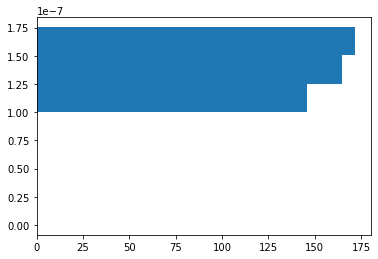

In [63]:
avg_range = 100
plot_bins = t_sim_bins[::avg_range]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(det_events*t_res, bins=plot_bins, orientation='horizontal')
plt.show()